# Daylight Savings Legislation

This notebook scrapes data from the National Conference of State Legislatures on state legislation to on daylight saving time in 2020, 2021 and 2022. It creates graphics in plotnine to visualize that legislation. 

It also scrapes the latitude and longitude of about 975 U.S. cities from uses the API from [LatLong.net](https://www.latlong.net/category/cities-236-15-1.html) and uses that geographic information to pull sunrise and sunset times from the [sunrise-sunset.org API](https://sunrise-sunset.org/api). These times are modified to show the time of sunrise and sunset on Jan. 1, 2022 if the U.S. observed daylight saving time year-round. 

In [3]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
from plotnine import *
import matplotlib.pyplot as plt
import re
import time

In [4]:
plt.rcParams['svg.fonttype'] = 'none'

## Legislation

Scraping the National Conference of State Legislature's [data](https://www.ncsl.org/research/transportation/daylight-savings-time-state-legislation.aspx) on state bills to change clock-switching. 

In [5]:
url = 'https://www.ncsl.org/research/transportation/daylight-savings-time-state-legislation.aspx'

In [6]:
raw_html = requests.get(url).content
soup = BeautifulSoup(raw_html, "html.parser")

In [7]:
def scrape_table(index, year):
    html = soup.find_all('table')[index]
    table = []
    for i, tr in enumerate(html.find_all('tr')[1:]):
        row = {}
        try:
            row['state'] = tr.find_all('td')[0].get_text()
            if row['state'] == u'\xa0':
                row['state'] = table[i-1]['state']
            row['bill_no'] = tr.find_all('td')[1].get_text()
            row['primary_sponsor'] = tr.find_all('td')[2].get_text()
            row['status'] = tr.find_all('td')[3].get_text()
            row['summary'] = tr.find_all('td')[4].get_text()
            try: 
                row['bill_link'] = tr.find_all('td')[1].find('a')['href']
            except: #If bill doesn't have hyperlink, skip
                pass
            table.append(row)
        except: #If there's more than one bill per state (2021 and 2022), shift indexes of cells
            row['state'] = table[i-1]['state']
            row['bill_no'] = tr.find_all('td')[0].get_text()
            row['primary_sponsor'] = tr.find_all('td')[1].get_text()
            row['status'] = tr.find_all('td')[2].get_text()
            try: 
                row['summary'] = tr.find_all('td')[3].get_text()
            except: #If multiple bills do the same thing, use summary from previous row
                row['summary'] = table[i-1]['summary']
            try:
                row['bill_link'] = tr.find_all('td')[0].find('a')['href']
            except: #If bill doesn't have hyperlink, skip
                pass
            table.append(row)
    table_clean = []
    for row in table:
        row_clean = {}
        for index, cell in enumerate(row.values()):
            cell = cell.replace('\n', '').replace('\t', '')
            row_clean[list(row.keys())[index]] = cell
        table_clean.append(row_clean)
    df = pd.DataFrame(table_clean)
    df['year'] = year
    return df

In [8]:
#Index is based on table placement on the webpage; they are in reverse chronological order here
state_bills22 = scrape_table(0, 2022) 
state_bills21 = scrape_table(1, 2021)
state_bills20 = scrape_table(2, 2020)

In [9]:
all_years = pd.concat([state_bills22, state_bills21, state_bills20])

In [10]:
def clean_table(table):
    table.loc[table.primary_sponsor.str.contains('R-'), 'party'] = 'R'
    table.loc[table.primary_sponsor.str.contains('D-'), 'party'] = 'D'
    table.loc[table.primary_sponsor.str.contains('I-'), 'party'] = 'I'
    table.bill_no = table.bill_no.str.replace(' \(', '(')

In [11]:
clean_table(all_years)

/var/folders/tx/ryc062z51z1287rjpvrp4jlc0000gn/T/ipykernel_24574/2501339832.py:5: FutureWarning: The default value of regex will change from True to False in a future version.


In [12]:
outcomes = all_years.groupby(['state', 'status', 'year']).bill_no.count().reset_index(name='num_outcomes')

In [13]:
outcomes.status.value_counts()

Pending                           43
Failed-Adjourned                  27
Failed                            18
Pre-filed                          3
Enacted                            3
Adopted                            2
Enacted (5/13/21)                  1
2020 Wyo. Sess. Laws, Ch. 134      1
Enacted (5/8/19)                   1
Enacted(3/28/2020)                 1
2020 S.C.Act 113(2/7/2020)         1
Failed Adjourned                   1
Enacted(5/10/21)                   1
Enacted(6/9/2020)                  1
Enacted(6/30/21)                   1
Amendment Failed                   1
2020 Idaho Sess. Laws, Ch. 145     1
FailedAdjourned                    1
Enacted(4/21/21)                   1
Adopted(3/9/2020)                  1
Adopted(4/15/21)                   1
Name: status, dtype: int64

In [28]:
outcomes.status = \
                outcomes.status.str.replace(r'\(.*', '').str.strip()\
                .str.replace('Failed Adjourned', 'Failed')\
                .str.replace('FailedAdjourned', 'Failed')\
                .str.replace('Failed-Adjourned', 'Failed')\
                .str.replace('Amendment Failed', 'Failed')\
                .str.replace(r'2020.*', 'Enacted')\
                .str.replace('Adopted', 'Enacted')


/var/folders/tx/ryc062z51z1287rjpvrp4jlc0000gn/T/ipykernel_24574/2295436383.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
/var/folders/tx/ryc062z51z1287rjpvrp4jlc0000gn/T/ipykernel_24574/2295436383.py:7: FutureWarning: The default value of regex will change from True to False in a future version.


In [29]:
enacted_states = outcomes[outcomes.status == 'Enacted']


In [30]:
outcomes.drop(outcomes[outcomes.status == 'Pre-filed'].index, inplace=True)

In [31]:
outcomes = outcomes.sort_values('state')

In [32]:
outcomes = outcomes.sort_values('status')

In [ ]:
states = list(outcomes.state.unique())

tile_chart = (
    ggplot(outcomes)
    + geom_tile(aes(x='year', y='state', fill='status'), color = "white", size=0.2)#
    + scale_fill_manual(['#A8E799', '#F89176', '#FAE688'])
    + theme_minimal()
    + scale_y_discrete(limits=states[::-1])
    + theme(panel_grid_major=element_blank(),
            panel_grid_minor=element_blank())
    + labs(title='28 states are considering legislation on Daylight Saving Time in 2022',
           x='', 
           y='')
)

display(tile_chart)

In [ ]:
tile_chart.save('states_tiles.svg')

In [33]:
outcomes_enacted = outcomes[(outcomes.state.isin(list(outcomes[outcomes.status == 'Enacted'].state))) &\
                           (outcomes.year != 2022)]

In [34]:
outcomes_2022_states = list(outcomes[outcomes.year==2022].state.unique())
outcomes_2022 = outcomes[outcomes.state.isin(outcomes_2022_states)]

In [35]:
#Manual sort for chart
enacted_states = pd.DataFrame(
                ['Alabama', 'Georgia', 'Ohio', 'Maine',
                  'Minnesota', 'Mississippi', 'Montana',
                 'Idaho', 'Louisiana', 'South Carolina',
                 'Utah', 'Washington', 'Wyoming'])

In [36]:
enacted_states = enacted_states.reset_index()
enacted_states.columns = ['state_rank', 'state']
outcomes_enacted = outcomes_enacted.merge(enacted_states, on='state')

In [ ]:
order = list(outcomes_enacted.sort_values('state_rank').state.unique())

enacted_chart = (
    ggplot(outcomes_enacted)
    + geom_tile(aes(x='year', y='state', fill='status'), color = "white", size=0.2)
    + scale_fill_manual(['#A8E799', '#F89176', '#FAE688'])
    + theme_minimal()
    + scale_y_discrete(limits=order[::-1])
    + theme(panel_grid_major=element_blank(),
            panel_grid_minor=element_blank())
    + labs(title='17 states have adopted or enacted legislation on Daylight Saving Time over the past two years',
           x='', 
           y='')
)
display(enacted_chart)

enacted_chart.save('enacted.svg')
#Requires manual cleaning and color correcting in Illustrator

In [37]:
#Manual sorting
pending_states = pd.DataFrame(
                ['Alaska', 'California', 'Iowa', 'Kansas', 'Kentucky', 'Maryland',
                 'Massachusetts', 'Michigan', 'Minnesota', 'Nebraska', 'New Hampshire',
                 'New Jersey', 'North Carolina', 'Ohio', 'South Carolina', 'South Dakota',
                 'Utah', 'Colorado', 'Missouri', 'Vermont', 'Virginia', 'Washington', 
                 'West Virginia', 'Georgia', 'Illinois', 'New York', 'Oklahoma', 
                 'Pennsylvania'])
pending_states = pending_states.reset_index()
pending_states.columns = ['state_rank', 'state']
outcomes_2022 = outcomes_2022.merge(pending_states, on='state')

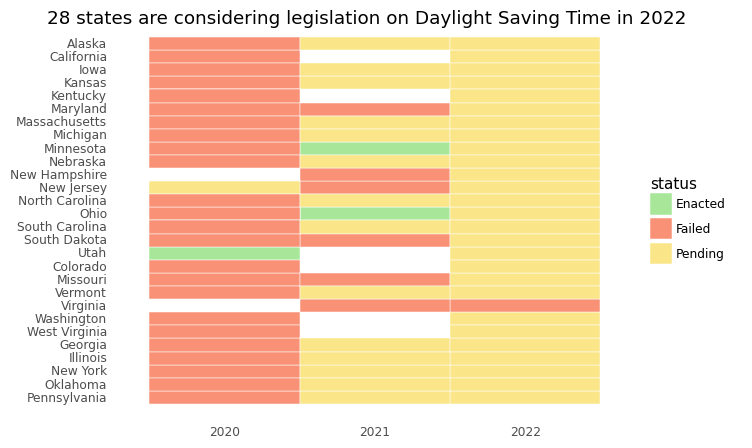

<ggplot: (326082518)>

/Users/jmingram/.pyenv/versions/3.10.0/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/jmingram/.pyenv/versions/3.10.0/lib/python3.10/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: 2022.svg


In [38]:
order = list(outcomes_2022.sort_values('state_rank').state.unique())

chart_2022 = (
    ggplot(outcomes_2022)
    + geom_tile(aes(x='year', y='state', fill='status'), color  = "white", size=0.2)
    + scale_fill_manual(['#A8E799', '#F89176', '#FAE688'])
    + theme_minimal()
    + scale_y_discrete(limits=order[::-1])
    + theme(panel_grid_major=element_blank(),
            panel_grid_minor=element_blank())
    + labs(title='28 states are considering legislation on Daylight Saving Time in 2022',
           x='', 
           y='')
)
display(chart_2022)

chart_2022.save('2022.svg')

## Sunrise and Sunset

Steps:
1. Scrape lat long of US cities from https://www.latlong.net/category/cities-236-15-1.html
2. Create a function to pull sunrise/sunset times from https://sunrise-sunset.org/api on a given day
3. Adjust for time zones
4. Map what it would be like without daylight savings on that given day

In [370]:
alldfs = []
for page in range(1,11):
    cities = []
    if page == 1:
        url_latlng = 'https://www.latlong.net/category/cities-236-15.html'
    else:
        url_latlng = 'https://www.latlong.net/category/cities-236-15-' + str(page) + '.html'
    raw_html_latlng = requests.get(url_latlng).content
    soup_latlng = BeautifulSoup(raw_html_latlng, "html.parser")
    for row in soup_latlng.find_all('tr')[1:]:
        city = {}
        city['name'] = row.find_all('td')[0].get_text()
        city['lat'] = row.find_all('td')[1].get_text()
        city['lng'] = row.find_all('td')[2].get_text()
        cities.append(city)
    df = pd.DataFrame(cities)
    alldfs.append(df)
cities_geo = pd.concat(alldfs)

In [371]:
def clean_cities_df(df):
    df = df.drop_duplicates()
    df['request_url'] = 'https://api.sunrise-sunset.org/json?lat=' + df.lat + '&lng=' + df.lng + '&date=2022-01-01'   
    names_clean = df.name.str.split(', ', 2, expand=True)
    names_clean.columns = ['city', 'state', 'country']
    df = names_clean.join(df)
    df.drop(columns=['name', 'country'], inplace=True)
    return df

In [375]:
newdfs = []
for df in alldfs:
    newdfs.append(clean_cities_df(df))

In [377]:
cities_geo = clean_cities_df(cities_geo)

/var/folders/tx/ryc062z51z1287rjpvrp4jlc0000gn/T/ipykernel_6558/3972240865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [378]:
def get_sunrise(url):
    return requests.get(url).json()['results']['sunrise']
def get_sunset(url):
    return requests.get(url).json()['results']['sunset']

In [380]:
#Takes a few minutes
for index, df in enumerate(newdfs):
    print('Starting page: ', str(index+1))
    df['sunrise_2022-01-01'] = df.request_url.apply(lambda x:get_sunrise(x))

Starting page:  1
Starting page:  2
Starting page:  3
Starting page:  4
Starting page:  5
Starting page:  6
Starting page:  7
Starting page:  8
Starting page:  9
Starting page:  10


In [382]:
#Takes a few minutes
for index, df in enumerate(newdfs):
    print('Starting page: ', str(index+1))
    df['sunset_2022-01-01'] = df.request_url.apply(lambda x:get_sunset(x))

Starting page:  1
Starting page:  2
Starting page:  3
Starting page:  4
Starting page:  5
Starting page:  6
Starting page:  7
Starting page:  8
Starting page:  9
Starting page:  10


In [383]:
cities_geo = pd.concat(newdfs)

In [390]:
cities_geo['sunrise_2022-01-01'] = pd.to_datetime(cities_geo['sunrise_2022-01-01'])
cities_geo['sunset_2022-01-01'] = pd.to_datetime(cities_geo['sunset_2022-01-01'])

In [391]:
#!pip install timezonefinder[numba] 
from timezonefinder import TimezoneFinder
tf = TimezoneFinder()

In [392]:
from datetime import timedelta

In [393]:
def adjust_timezone_DST(place, latitude, longitude, time):
    timezone = tf.timezone_at(lng=float(longitude), lat=float(latitude))
    if timezone == 'America/Los_Angeles':
        return time - timedelta(hours=7)
    elif timezone == 'America/Boise':
        return time - timedelta(hours=6)
    elif timezone == 'America/Chicago':
        return time - timedelta(hours=5)
    elif timezone == 'America/New_York':
        return time - timedelta(hours=4)

In [395]:
cities_geo['sunrise_2022-01-01'] = cities_geo.apply(lambda x:adjust_timezone_DST(x.name, x.lat, x.lng, x['sunrise_2022-01-01']), axis=1)
cities_geo['sunset_2022-01-01'] = cities_geo.apply(lambda x:adjust_timezone_DST(x.name, x.lat, x.lng, x['sunset_2022-01-01']), axis=1)

In [402]:
cities_geo['sunrise_str'] = cities_geo['sunrise_2022-01-01'].dt.strftime('%H%M%S')
cities_geo['sunset_str'] = cities_geo['sunset_2022-01-01'].dt.strftime('%H%M%S')

In [403]:
cities_geo.to_csv('cities_geo_sunrise_sunset_JanDST.csv')

In [397]:
cities_geo.dtypes

city                          object
state                         object
lat                           object
lng                           object
request_url                   object
sunrise_2022-01-01    datetime64[ns]
sunset_2022-01-01     datetime64[ns]
dtype: object

In [410]:
cities_geo.sort_values('sunset_str')

,city,state,lat,lng,request_url,sunrise_2022-01-01,sunset_2022-01-01,sunrise_str,sunset_str
16,Bonners Ferry,ID,48.692551,-116.319862,https://api.sunrise-sunset.org/json?lat=48.692...,2022-03-11 08:36:00,2022-03-10 17:01:59,083600,170159
13,Kellogg,ID,47.538658,-116.129227,https://api.sunrise-sunset.org/json?lat=47.538...,2022-03-11 08:30:32,2022-03-10 17:05:55,083032,170555
98,Bangor,ME,44.808147,-68.795013,https://api.sunrise-sunset.org/json?lat=44.808...,2022-03-11 08:10:58,2022-03-11 17:06:41,081058,170641
14,Coeur d’Alene,ID,47.702465,-116.796883,https://api.sunrise-sunset.org/json?lat=47.702...,2022-03-11 08:33:51,2022-03-10 17:07:57,083351,170757
84,Post Falls,ID,47.712257,-116.948364,https://api.sunrise-sunset.org/json?lat=47.712...,2022-03-11 08:34:30,2022-03-10 17:08:31,083430,170831
...,...,...,...,...,...,...,...,...,...
45,Anderson,IN,40.109589,-85.676964,https://api.sunrise-sunset.org/json?lat=40.109...,NaT,NaT,NaN,NaN
61,Detroit,Michigan,42.331429,-83.045753,https://api.sunrise-sunset.org/json?lat=42.331...,NaT,NaT,NaN,NaN
74,Southfield,MI,42.475136,-83.221275,https://api.sunrise-sunset.org/json?lat=42.475...,NaT,NaT,NaN,NaN
76,Richfield,Utah,38.769287,-112.088409,https://api.sunrise-sunset.org/json?lat=38.769...,NaT,NaT,NaN,NaN
